#  Hidden Markov Model with Gaussian-distributed observed variables

The aim of this notebook is to implement the EM algorithm of an HMM with multinomial latent variable and Gaussian-distributed observed variables.

In [86]:
import os
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from io import StringIO

In [2]:
%config InlineBackend.figure_format = "retina"

Let ${\bf X}=\{{\bf x}_n \vert {\bf x}_n \in \mathbb{R}^M\}_{n=1}^N$ be an sequential dataset of observed variables. We define a Hidden Markov Model (HMM) by introducing a set of unobserved (latent) variables ${\bf Z}=\{{\bf z}_n\}_{n=1}^N$. We define the relationship between ${\bf X}$ and ${\bf Z}$ as the following graph:

![Hidden Markov Model](https://imgur.com/1YC0iu0.png)

The joint distribution of an HMM is given by

$$
    p({\bf x}_1, \ldots, {\bf x}_n, {\bf z}_1, {\bf z}_N) = p({\bf z}_1)\prod_{n=1}^N p({\bf z}_n\vert {\bf z}_{n-1})\prod_{n=1}^N p({\bf x}_n \vert {\bf z}_n)
$$

With 

$$
    p({\bf z}_1\vert\boldsymbol\pi) = \prod_{k=1}^K \pi_k^{z_{1k}}
$$

We define the *emission* probabilities as

$$
p({\bf x}_n\vert {\bf z}_n, \boldsymbol\phi) = \prod_{k=1}^K p({\bf x}_n\vert\phi_k)^{z_{nk}} = \prod_{k=1}^K \left(\mathcal{N}({\bf x}_n\vert \boldsymbol\mu_k, \boldsymbol\Sigma_k)\right)^{z_{nk}}
$$

## HMM via the EM algorithm

In order to find the values $\boldsymbol\theta = \{\boldsymbol\pi, A, \boldsymbol\phi\}$, we make use of the EM algorithm. We perform a step of the EM algorith for an HMM as follows:

* **E-Step**: Compute $p({\bf Z}\vert{\bf X}, \boldsymbol\theta)$
* **M-Step**: Find $\boldsymbol\theta^{\text{new}}=\arg\max_{\boldsymbol\theta} Q(\boldsymbol\theta, \boldsymbol\theta^{\text{old}})$.

----

By writing the expected complete-data log-likelihood, we obtain an expression of the form

$$
   Q(\boldsymbol\theta, \boldsymbol\theta^{\text{old}}) = \sum_{k=1}^K \log\pi_k \gamma(z_{1k}) + \sum_{n=2}^N\sum_{j=1}^K\sum_{k=1}^K \xi(z_{n-1,j}, z_{n,k}) \log A_{jk} + \sum_{n=1}^N\sum_{k=1}^K \log p({\bf x}_n\vert\phi_k) \gamma(z_{nk})
$$

With updating equations


### E-Step

* $\gamma(z_{nk}) = \mathbb{E}[z_{nk}]$
* $\xi(z_{n-1,j}, z_{n,k}) = \mathbb{E}[z_{n-1, j} \cdot z_{n,k}]$

### M-Step

The M-step updating equations become

$$
    \pi_k = \frac{\gamma(z_{1k})}{\sum_{j=1}^K \gamma(z_{1j})}
$$


$$
    A_{jk} = \frac{\sum_{n=2}^N \xi(z_{n-1, k}, z_{nk})}{\sum_{l=1}^K\sum_{n=2}^N \xi(z_{n-1, k}, z_{nl})}
$$

To compute $\forall n,k,k:\gamma(z_{nk}), \xi(z_{n-1, j}, z_{nk})$, we require to obtain the values for

$$
    \gamma({\bf z}_n) = \frac{ \alpha({\bf z}_n)\beta({\bf z}_n) }{p({\bf X})}
$$

$$
    \xi({\bf z}_{n-1}, {\bf z}_n) = \frac{\alpha({\bf z}_{n-1}) p({\bf x}_n\vert {\bf z}_n) p({\bf z}_{n-1}\vert {\bf z}_n) \beta({\bf z}_n)}{p({\bf X})}
$$


Where $\alpha({\bf z}_n)$ and $\beta({\bf z})$ are recursive relations of the form

$$
    \alpha({\bf z}_n) = p({\bf x}_n\vert{\bf z}_n)\sum_{{\bf z}_{n-1}} \alpha({\bf z}_{n-1})p({\bf z}_n\vert {\bf z}_{n-1})
$$

$$
    \beta({\bf z}_n) = \sum_{{\bf z}_{n+1}} p({\bf x}_{n+1}\vert{\bf z}_{n+1})p({\bf z}_{n+1} \vert {\bf z}_n)
$$


With initial conditions

* $\alpha(z_{1k}) = \pi_k p(x_1\vert\phi_k)$
* $\beta(z_{Nk}) = 1$

$\alpha$ and $\beta$ are respectively known as the *Forward Message Passing* and *Backwards Message Passing*

### Modeling spread between MXN and BRL

* <strong style="color:crimson">Note</strong>: This is not a perfect example to use an HMM, as the bimodality in the distribution appears to correspond to different time periods and are not time indepenent.

In [3]:
def download_fx_daily(from_symbol, to_symbol, api_key):
    """
    Download the historical data of to_symbol currency
    in terms of from_symbol.
    
    Obtain your api from
            https://www.alphavantage.co/support/#api-key
    """
    url = "https://www.alphavantage.co/query"
    params = {
        "function": "FX_DAILY",
        "from_symbol": from_symbol,
        "to_symbol": to_symbol,
        "outputsize": "full",
        "datatype": "csv",
        "apikey": api_key
    }
    
    r = requests.get(url, params=params)
    df = pd.read_csv(StringIO(r.text), index_col=0)
    df = df.set_index(pd.to_datetime(df.index)).sort_index()
    
    return df

In [187]:
apikey = os.environ["AVANTAGE_API"]
df_mxn = download_fx_daily("MXN", "USD", apikey)
df_brl = download_fx_daily("BRL", "USD", apikey)
df = (df_brl - df_mxn).dropna()

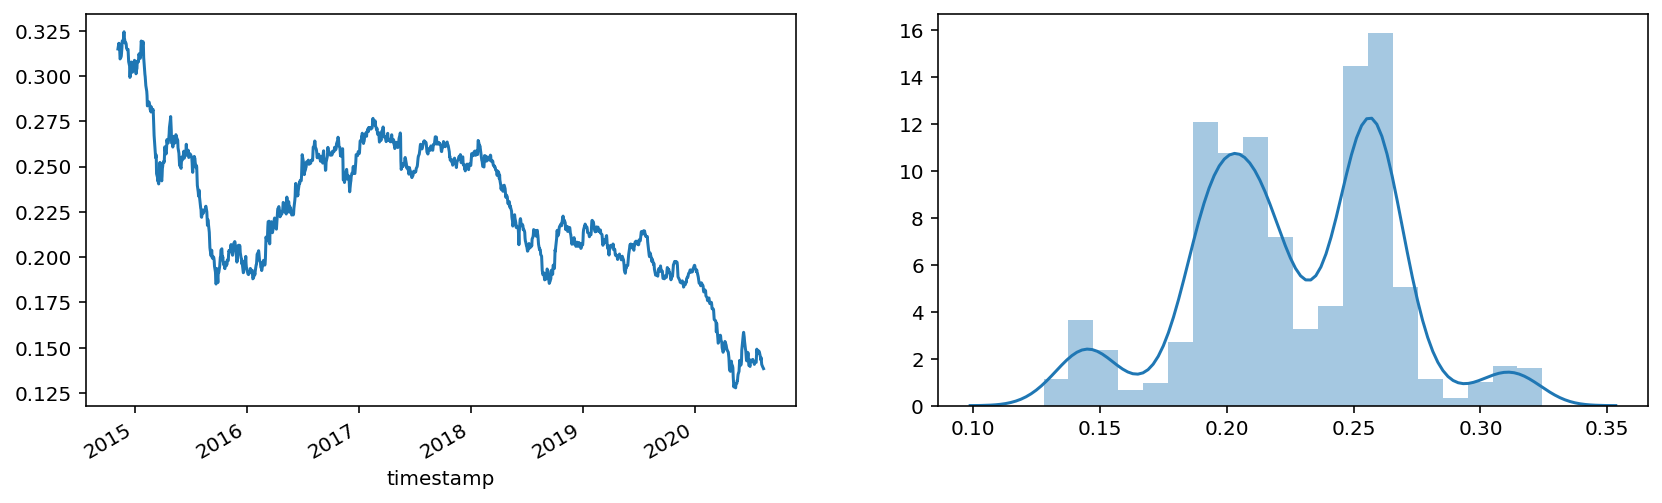

In [188]:
df_mxn_brl = (df["high"] + df["low"]) / 2
N, *_ = df_mxn_brl.shape

fig, ax = plt.subplots(1, 2, figsize=(14, 4))
df_mxn_brl.plot(ax=ax[0])
sns.distplot(df_mxn_brl, ax=ax[1])

In [189]:
X = df_mxn_brl.copy()

## The E-Step

In [193]:
from numpy.random import random, seed
seed(314)

K = 3
# initial parameters for the latent variables
pi = random(K)
pi = pi / pi.sum()
A = random((K, K))
A = A / A.sum(axis=1, keepdims=True)

# Initial parameters for the observed distribution
mus = random(K)
sigmas = random(K)

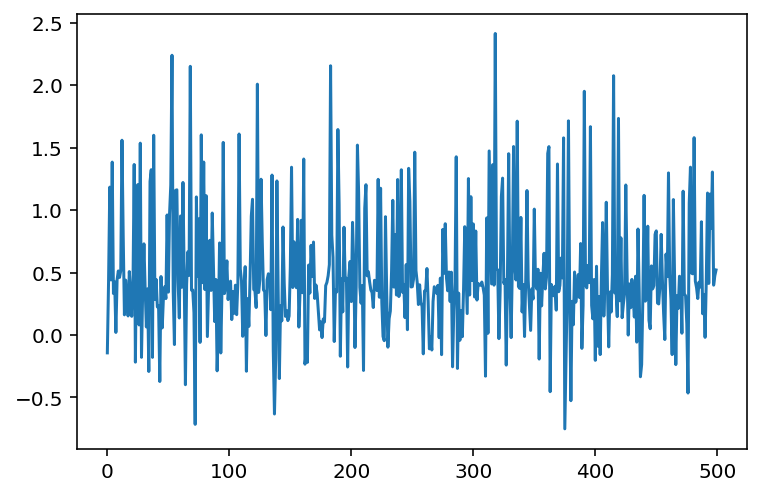

In [195]:
# Simulation before parameter learning
z = np.arange(K)

seed(314)
n_samples = 500
samples = np.zeros(n_samples)
zi = np.random.choice(z, p=pi)

for n in range(n_samples):
    Nx = norm(loc=mus[zi], scale=sigmas[zi])
    samples[n] = Nx.rvs()
    
    zi = np.random.choice(z, p=A[zi])

plt.plot(samples)

#### Forward message-passsing

$$
    \alpha({\bf z}_n) = p({\bf x}_n\vert{\bf z}_n)\sum_{{\bf z}_{n-1}} \alpha({\bf z}_{n-1})p({\bf z}_n\vert {\bf z}_{n-1})
$$

* $\alpha(z_{1k}) = \pi_k p(x_1\vert\phi_k)$

In [196]:
Nx = norm(loc=mus, scale=sigmas)

In [197]:
# Initial "message"
a1 = pi * Nx.pdf(X.iloc[0])

# Second "message"
a2 = Nx.pdf(X.iloc[1]) * (a1[:, None] * A).sum(axis=0)

# third message
a3 = Nx.pdf(X.iloc[2]) * (a2[:, None] * A).sum(axis=0)

In general, we can write the forward message passing as follows:

In [198]:
alpha_values = np.zeros((N, K))

for n, (_, xn) in enumerate(X.iteritems()):
    if n == 0:
        an = pi * Nx.pdf(xn)
    else:
        an = Nx.pdf(xn) * (an[:, None] * A).sum(axis=0)
    alpha_values[n] = an

In [199]:
alpha_values

array([[5.84394934e-001, 1.13090048e+000, 6.68722956e-002],
       [7.02847674e-001, 1.44792520e+000, 3.35245393e-001],
       [9.44730300e-001, 2.26846326e+000, 4.44302775e-001],
       ...,
       [1.78495759e-207, 1.96180828e-209, 4.47475192e-208],
       [9.31872291e-208, 1.01131564e-209, 2.33490603e-208],
       [4.86437237e-208, 5.17299369e-210, 1.21783506e-208]])

#### Backward message-passsing

$$
    \beta({\bf z}_n) = \sum_{{\bf z}_{n+1}} \beta({\bf z}_{n+1})  p({\bf x}_{n+1}\vert{\bf z}_{n+1}) p({\bf z}_{n+1}\vert {\bf z}_{n})
$$

* $\beta(z_{Nk}) = 1$

In [200]:
# final message
b1 = np.ones(K)

# final - 1 message
b2 = (b1 * Nx.pdf(X.iloc[-2]) * A).sum(axis=1)

In general, we can write the backward message passing as follows:

In [201]:
beta_values = np.zeros((N, K))

for n, (_, xn) in enumerate(X[::-1].shift(1).iteritems()):
    if n == 0:
        bn = 1
    else:
        bn = (bn * Nx.pdf(xn) * A).sum(axis=1)
    
    beta_values[n] = bn

beta_values = beta_values[::-1]

In [202]:
beta_values

array([[4.14013520e-208, 2.97183502e-208, 5.28789510e-208],
       [2.81387606e-208, 2.04434767e-208, 3.56797928e-208],
       [1.95274575e-208, 1.40243428e-208, 2.49322921e-208],
       ...,
       [2.91500736e-001, 3.67441610e-001, 1.91896195e-001],
       [5.58956486e-001, 7.13570541e-001, 3.65330440e-001],
       [1.00000000e+000, 1.00000000e+000, 1.00000000e+000]])

#### The likelihood $p(X)$

Once obtained $\forall n: \alpha({\bf z}_n), \beta({\bf z}_n)$, we can compute the likelihood $p({\bf X})$ in the form

$$
    p({\bf X}) = \sum_{{\bf z}_n} \alpha({\bf z}_n) \beta({\bf z}_n)
$$

Or, more specifically,

$$
    p({\bf X}) = \sum_{{\bf z}_N} \alpha({\bf z}_N)
$$

In [203]:
alpha_values[-1].sum()

6.133937364530739e-208

In [204]:
(alpha_values[2] * beta_values[2]).sum()

6.133937364530718e-208

In [205]:
(alpha_values[100] * beta_values[100]).sum()

6.133937364530718e-208

In [206]:
likelihood = alpha_values[-1].sum()

#### $\gamma$, $\xi$ values

With $\alpha({\bf z}_n)$, $\beta({\bf z}_n)$, and $p({\bf X})$, we can write 

$$
    \gamma({\bf z}_n) = \frac{\alpha({\bf z}_n) \beta({\bf z}_n)}{p({\bf X})}
$$

$$
    \xi({\bf z}_{n-1}, {\bf z}_n) = \frac{\alpha({\bf z}_{n-1}) p({\bf x}_n\vert {\bf z}_n) p({\bf z}_n\vert {\bf z}_{n-1})\beta({\bf z}_n)}{p(\bf X)}
$$

In [207]:
gamma = alpha_values * beta_values / likelihood

In [261]:
# p(xn|zn) # to-do: optimize for-loop
p_xz = np.r_[[Nx.pdf(x) for x in X]]
xi = (alpha_values[:-1][..., None] * p_xz[1:, None, :] * A[None, ...] * beta_values[1:, None, :]) / likelihood

## The M-step